# Knowdge Distillation using Contrastive Learning


 #### Student Name: Radin Shahdaei


 #### Student ID: 401106096


In this exercise, we aim to distill knowledge from a large monolingual model into a smaller multilingual model using contrastive learning, specifically leveraging the CLIP model loss.

We employ a small paired English-Persian dataset to define the loss pairs for our CLIP training. Given the substantial dataset size and batch size typically required for CLIP's loss computation (exceeding 19,000 samples per batch in standard tasks), which is impractical for our setup on Colab, we use a reduced batch size to focus on learning the procedure rather than achieving optimal performance, so we don't expect actual real-world results, only the training prcodure.

CLIP (Contrastive Language-Image Pretraining) is a foundational model introduced by OpenAI to bridge the gap between text and image modalities. By aligning text descriptions and corresponding images in a shared embedding space, CLIP achieves remarkable zero-shot generalization capabilities across a wide range of tasks. It is trained on a massive dataset of image-text pairs using contrastive loss, ensuring that image embeddings align closely with their corresponding textual descriptions while remaining distinct from unrelated samples. This cross-modal alignment enables CLIP to perform tasks like image retrieval, captioning, and classification with minimal fine-tuning.

The CLIP loss plays a crucial role in training the model by implementing a cross-entropy loss function in the contrastive learning framework. This loss operates on paired data, where each image-text pair is treated as a positive match, while all other pair combinations in the batch are considered negatives. The loss ensures that positive pairs receive high similarity scores, while negatives are penalized. However, achieving optimal results with CLIP loss often requires large batch sizes to provide sufficient negative samples, which can be computationally intensive. This makes training with limited resources challenging, necessitating adaptations such as smaller batch sizes or alternative strategies to approximate the training dynamics.


Knowledge distillation is a technique used in machine learning to transfer knowledge from a large, complex model (the "teacher") to a smaller, more efficient model (the "student"). The primary goal of this process is to retain the performance and accuracy of the larger model while significantly reducing computational and memory requirements. This is achieved by training the student model to mimic the outputs of the teacher model, often through techniques such as matching soft probability distributions or intermediate representations. Knowledge distillation has become an essential approach in deploying machine learning models on resource-constrained devices such as smartphones and edge devices.

In practice, knowledge distillation is not limited to replicating predictions; it can also involve transferring knowledge about internal features or learned representations.


### Challenges in Resource-Constrained Settings
CLIP’s reliance on large-scale datasets and batch sizes makes direct implementation computationally demanding. This exercise demonstrates an adaptation of the process, reducing batch size and dataset size to provide a practical understanding of the training procedure. While this approach sacrifices performance and real-world applicability, it highlights the mechanics of using CLIP loss for contrastive learning and lays the foundation for extending the process to larger datasets and batch sizes in future applications.



### About CLIP and Contrastive Learning
CLIP, developed by OpenAI, bridges the gap between text and image modalities by aligning corresponding embeddings in a shared space. It leverages contrastive loss to train on image-text pairs, ensuring that embeddings of positive pairs (e.g., an image and its corresponding caption) are highly similar, while embeddings of unrelated pairs remain distinct. The cross-entropy-based contrastive loss evaluates the similarity between positive pairs while penalizing mismatches for all other combinations within a batch.

### Key aspects of CLIP loss include:

- Positive Pairing: Encourages high similarity scores for embeddings of paired text and image data.
- Negative Sampling: Penalizes mismatched pairs within the batch, requiring large batch sizes for effective performance due to the need for a diverse set of negative samples.



## !!! Note !!! You Should Answer to all the TODOs

Also feel free to ask your questions on Quera.



## Setup


We install Required Packages.

In [1]:
!pip install -q gdown
!gdown "https://drive.google.com/uc?id=1MVx_gIkX4tQ8ya2OsHt0mqLmw1Pf2CcK"
!gdown "https://drive.google.com/uc?id=1Co-dwJfWw-C_ral0hoAS_X94wN-_vbCj"

Downloading...
From: https://drive.google.com/uc?id=1MVx_gIkX4tQ8ya2OsHt0mqLmw1Pf2CcK
To: /content/train.csv
100% 7.35M/7.35M [00:00<00:00, 45.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Co-dwJfWw-C_ral0hoAS_X94wN-_vbCj
To: /content/val.csv
100% 2.45M/2.45M [00:00<00:00, 20.6MB/s]


In [2]:
!pip install setuptools
import sys
import subprocess
import pkg_resources

def installPackages(packages):
    def installPackage(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    for package in REQUIRED_PACKAGES:
        try:
            dist = pkg_resources.get_distribution(package)
            print('{} ({}) is installed'.format(dist.key, dist.version))
        except pkg_resources.DistributionNotFound:
            print('{} is NOT installed'.format(package))
            installPackage(package)
            print('{} was successfully installed.'.format(package))

REQUIRED_PACKAGES = [
    'open_clip-torch',
    'pandas',
    'numpy',
    'matplotlib',
    'transformers',
    'tqdm',
    'torch',
    'datasets',
]

installPackages(REQUIRED_PACKAGES)

import gc
import itertools
import re
import math
from collections import Counter
import random
import string
import uuid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import open_clip
from open_clip import model as TE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from datasets import load_dataset, Dataset, Features, Array2D, Value
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel

from tqdm import tqdm

<ipython-input-2-16d6a20cb021>:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


open_clip-torch is NOT installed
open_clip-torch was successfully installed.
pandas (2.2.2) is installed
numpy (1.26.4) is installed
matplotlib (3.10.0) is installed
transformers (4.47.1) is installed
tqdm (4.67.1) is installed
torch (2.5.1+cu121) is installed
datasets is NOT installed
datasets was successfully installed.


Beware to use cuda for training!

In [3]:
def getDevice(which="cuda:0", yellAtCpu=True):
    if torch.cuda.is_available():
        device = torch.device(which)
    else:
        if yellAtCpu:
             raise Exception("I won't run on CPU!")
        device = torch.device("cpu")

    return device

#### Configs

These are our training configurations, read them!

In [29]:
def Configs():
    return {
        "device": getDevice(),
        "reference_checkPoint" : "EVA02-E-14-plus",                # teacher
        "candidate_checkpoint" : "setu4993/smaller-LaBSE",         # student
        "train_path" : "train.csv",
        "val_path" : "val.csv",
        "save_path" : "./best-model.pth",
        "english" : "en",                                         # dont mind them
        "persian" : "fa",
        "batch_size": 128,                                        # should have been really big, but we can't here
        "lr": 1e-4,
        "epochs": 5,                                               # 40 minute per epoch
        "tok_percentile" : 99,
        "temperature": 20,
        "dropout": 0.05,
        "unfreezed_layers" : 10,
        "weight_decay": 1e-5,
        "patience": 1,
        "factor" : 0.8,
        "reference_embedding": 1024,                               # DONT MIND THESE
        "reference_context_length" : 77,
        "reference_vocab_size" : 49408,
        "reference_heads" : 20,
        "reference_width" : 1280,
        "reference_layers" : 32,
        "cls_token_index" : 0,
        "project_to" : 1024,
    }

configs = Configs()

## Question Box
### TODO (10pts)
**1- Why do we use temperature in training using contrastive learning?**

Temperature scales the similarity scores in the contrastive loss. A higher temperature makes the model less confident, encouraging exploration, while a lower temperature sharpens the differences between positive and negative pairs. This helps balance the model's confidence and improves generalization.


**2- Why do we need to freeze some layers of a model? mention 2 reasons.**

Prevent Overfitting: Freezing layers stops them from overfitting to the new dataset, especially when the dataset is small.

Preserve Pre-trained Knowledge: Freezing layers retains the learned features from the pre-trained model, allowing only specific layers to adapt to the new task.


**3- Read the whole code and find out what tok_percentile is used for.**

tok_percentile determines the maximum token length for padding or truncation. It calculates the token length at a specific percentile (e.g., 99th) from the dataset, ensuring most sequences fit without excessive padding or truncation.

## Data and Preprocessing

In [6]:
def getDatasetsCSV(prevEnCol, prevFaCol, newEnCol, newFaCol, trainPath, valPath):
    df = pd.read_csv(trainPath)
    dfVal = pd.read_csv(valPath)

    if df.empty:
        raise ValueError("Training dataset is empty or missing")

    if dfVal.empty:
        raise ValueError("Validation dataset is empty or missing")

    dfTraind = df.loc[:, [prevEnCol, prevFaCol]].rename(columns={prevEnCol: newEnCol, prevFaCol: newFaCol})
    dfVal = dfVal.loc[:, [prevEnCol, prevFaCol]].rename(columns={prevEnCol: newEnCol, prevFaCol: newFaCol})

    datasetTrain = Dataset.from_pandas(dfTraind)
    datasetVal = Dataset.from_pandas(dfVal)

    return datasetTrain, datasetVal

def getDsByLang(persianCol, englishCol):
    def getPersianDs(dataset):
        return dataset[persianCol]

    def getEnglishDs(dataset):
        return dataset[englishCol]

    getPersianDs.label = persianCol
    getEnglishDs.label = englishCol

    return getPersianDs, getEnglishDs

class Normalizer():
    def __init__(self):
        translation_src = ' ىكي“”0123456789%إأآئيؤةك'
        translation_dst = ' یکی""۰۱۲۳۴۵۶۷۸۹٪اااییوهک'

        self.translations = str.maketrans(translation_src, translation_dst)

        patterns = [
            (r' {2,}', ' '),  # remove extra spaces
            (r'\n+', ' '),  # replace newlines with space
            (r'\u200c+', ' '),  # replace ZWNJs with space
            (r'[ـ\r]', '')  # remove keshide, carriage returns
        ]

        self.character_refinement_patterns = [(re.compile(pattern), repl) for pattern, repl in patterns]

    def normalizeFa(self, text):
        text = text.lower().translate(self.translations)
        text = re.sub('[^a-zA-Z۰-۹آ-ی ]', ' ', text)

        for pattern, repl in self.character_refinement_patterns:
            text = pattern.sub(repl, text)
        return text.strip()

    def normalizeEn(self, text):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
        return text

def applyPreprocess(datasets, configs=configs, Normalizer=Normalizer):
    def applyRowNormalization(example):
        example[configs['persian']] = normalizer.normalizeFa(example[configs['persian']])
        example[configs['english']] = normalizer.normalizeEn(example[configs['english']])

        return example

    normalizer = Normalizer()

    newDatasets = []
    for dataset in datasets:
        newDatasets.append(dataset.map(applyRowNormalization))

    return newDatasets

def preprocessSentence(text, lang, mostFreq=None, Normalizer=Normalizer, configs=configs):
    normalizer = Normalizer()
    if lang == configs['persian']:
        normalized = normalizer.normalizeFa(text)
    elif lang == configs['english']:
        normalized = normalizer.normalizeEn(text)
    else:
        raise ValueError("Not supported lang")

    return normalized

## Utils
### TODO: Complete these Utility functions (10pts)

In [8]:
def getClsToken(tensor, configs=configs):
    clsId = configs["cls_token_index"]
    return tensor[:, clsId, :].unsqueeze(1)  # Extracts the CLS token and adds a dimension

def flattenMiddle(tensor):
    return tensor.mean(dim=1)  # Averages over the sequence length dimension

def freezeModel(model):
    for param in model.parameters():
        param.requires_grad = False  # Disable gradient computation for all parameters
    return model

In [7]:
def plotMetric(metricData, metricName):
    if metricName == None or metricName not in metricData:
        raise ValueError("No such metric")
    metricData[metricName].plot()
    plt.xlabel('Epochs')
    plt.ylabel(metricName)
    plt.title(f'Plot of {metricName}')
    plt.show()

threshold=1
def calcPrcentileTokens(dataset, tokenizer, field, percentile=configs["tok_percentile"], thershold=1):
    """
    Calculate the token length at a specific percentile for a dataset field.

    This function tokenizes the data in the specified field of the dataset and calculates
    the token length at the given percentile. An optional threshold can be added to the result.

    Parameters:
        dataset (dict or Dataset): The dataset containing the data to be tokenized.
        tokenizer (callable): A tokenizer function or object with a callable interface
                              (e.g., HuggingFace tokenizer).
        field (str): The field in the dataset whose token lengths are to be calculated.
        percentile (float, optional): The percentile to compute (default is the value in
                                       `configs["tok_percentile"]`).
        thershold (int, optional): A value to add to the calculated percentile token length
                                    (default is 1).

    Returns:
        int: The token length at the specified percentile plus the threshold.

    Raises:
        KeyError: If the specified field does not exist in the dataset.
        TypeError: If `tokenized` is not in the expected format.

    Example:
        dataset = {"text": ["This is a sentence.", "Another example sentence."]}
        tokenizer = lambda x: {"input_ids": [[1, 2, 3, 4], [5, 6, 7, 8, 9]]}
        field = "text"
        calcPrcentileTokens(dataset, tokenizer, field, percentile=95, thershold=2)

    Notes:
        - If the tokenized output is a dictionary (e.g., HuggingFace tokenizers), it assumes
          that `input_ids` contains the token sequences.
        - If the tokenized output is a tensor, nonzero token counts are used to determine lengths.
    """
    tokenized = tokenizer(dataset[field])
    if not isinstance(tokenized, torch.Tensor):
        tokenLengths = list(map(lambda sen: len(sen), tokenized['input_ids']))
    else:
        tokenLengths = [tensor.nonzero().size(0) for tensor in tokenized]
    percentileLength = np.percentile(tokenLengths, percentile)
    return int(percentileLength) + 1

# Dont Touch This
def TextEncoder(configs):
    newModel = TE.TextTransformer(context_length=configs['reference_context_length'],
                                 vocab_size=configs["reference_vocab_size"],
                                 width=configs["reference_width"],
                                 layers=configs["reference_layers"],
                                 heads=configs["reference_heads"],
                                 output_dim=configs["reference_embedding"])
    return newModel


## Models

### TODO: Compelete the Swish and LinearProjection functions based on the pydoc provided (15pts)

In [9]:
class Swish(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)  # Swish activation


class LinearProjection(nn.Module):
    def __init__(self, embedding_dim, projection_dim=configs['project_to'], dropout=configs['dropout']):
        super(LinearProjection, self).__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.swish = Swish(beta=1.0)
        self.batch_norm = nn.BatchNorm1d(projection_dim)  # Batch normalization
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)  # Dropout layer
        self.layer_norm = nn.LayerNorm(projection_dim)  # Layer normalization

    def forward(self, x):
        # Projection + Swish activation + batch normalization
        projected = self.batch_norm(self.swish(self.projection(x)))

        # Fully connected layer + dropout
        transformed = self.dropout(self.fc(projected))

        # Residual connection + layer normalization
        output = self.layer_norm(projected + transformed)

        return output

In [15]:
class CandidateModel(nn.Module):
    def __init__(self, model_name, unfreezeLayers, trainable=True):
        super().__init__()
        self.candidateProjection = LinearProjection(embedding_dim=configs["candidate_embedding"])
        self.configs = AutoConfig.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.batchNorm = nn.BatchNorm1d(1, configs["candidate_embedding"])
        self.targetTokenIdx = configs["cls_token_index"]

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        clsEmbed = getClsToken(output.last_hidden_state)
        clsEmbed = self.batchNorm(clsEmbed)
        clsEmbed = self.candidateProjection(flattenMiddle(clsEmbed))
        return clsEmbed

## Training

### TODO: Compelete the calcLoss functions based on the pydoc provided (20pts)

In [19]:
def calcLoss(batch, referenceModel, candidateModel, temperature):
    # Move tokenized inputs to the specified device
    candidateTokenized = batch["candidate"].to(configs["device"])
    referenceTokenized = batch["reference"].to(configs["device"])

    # Generate embeddings from reference and candidate models
    referenceEmbeds = referenceModel(referenceTokenized)
    candidateEmbeds = candidateModel(
        input_ids=candidateTokenized["input_ids"],
        attention_mask=candidateTokenized["attention_mask"]
    )

    # Normalize embeddings to have unit length
    referenceEmbeds = F.normalize(referenceEmbeds, p=2, dim=-1)
    candidateEmbeds = F.normalize(candidateEmbeds, p=2, dim=-1)

    # Compute scaled cosine similarity (logits)
    logits = (referenceEmbeds @ candidateEmbeds.T) / temperature

    # Create target labels (identity matrix for perfect alignment)
    batch_size = referenceEmbeds.size(0)
    targets = torch.arange(batch_size, device=configs["device"])  # Class indices (LongTensor)

    # Compute symmetric cross-entropy loss
    loss = (F.cross_entropy(logits, targets) + F.cross_entropy(logits.T, targets)) / 2

    # Calculate the number of correct predictions
    preds = torch.argmax(logits, dim=-1)
    corrects = torch.sum(preds == targets).item()

    return loss, corrects

### TODO: Fill the trainLoop and valLoop (5pts)

In [31]:
from tqdm import tqdm
import torch

def trainLoop(dataloader, models, referenceTokenizer, candidateTokenizer, optimizer, temperature):
    models['candidateModel'].train()  # Set candidate model to training mode

    totalLoss = 0.0
    totalCorrects = 0

    print("Training Starts!")
    for (index, pairs) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Tokenize Persian (candidate) and English (reference) text
        candidteTokenized = candidateTokenizer(
            getPersianDs(pairs),
            padding='max_length',
            truncation=True,
            return_tensors="pt",
            max_length=configs["fa_tok_percentile"]
        )
        referenceTextTokenized = referenceTokenizer(getEnglishDs(pairs))

        # Prepare batch
        batch = {
            "candidate": candidteTokenized,
            "reference": referenceTextTokenized
        }

        # Compute loss and correct predictions
        loss, corrects = calcLoss(batch, models['referenceModel'], models['candidateModel'], temperature)

        # Accumulate loss and correct predictions
        totalCorrects += corrects
        totalLoss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update model parameters

        # Optional: Print progress
        if index % 10 == 0:  # Print every 10 batches
            print(f"Batch {index}: Loss = {loss.item()}, Corrects = {corrects}")

    # Compute average loss and accuracy
    avgLoss = totalLoss / len(dataloader.dataset)
    avgAccuracy = totalCorrects / len(dataloader.dataset)

    print("Train Loss:", avgLoss)
    print("Train Accuracy:", avgAccuracy)

    return avgLoss, avgAccuracy


def valLoop(dataloader, models, referenceTokenizer, candidateTokenizer, temperature):
    models['candidateModel'].eval()  # Set candidate model to evaluation mode

    print("Validation Starts!")
    totalLoss = 0.0
    totalCorrects = 0

    with torch.no_grad():  # Disable gradient computation
        for (index, pairs) in tqdm(enumerate(dataloader), total=len(dataloader)):
            # Tokenize Persian (candidate) and English (reference) text
            candidteTokenized = candidateTokenizer(
                getPersianDs(pairs),
                padding='max_length',
                truncation=True,
                return_tensors="pt",
                max_length=configs["fa_tok_percentile"]
            )
            referenceTextTokenized = referenceTokenizer(getEnglishDs(pairs))

            # Prepare batch
            batch = {
                "candidate": candidteTokenized,
                "reference": referenceTextTokenized
            }

            # Compute loss and correct predictions
            loss, corrects = calcLoss(batch, models['referenceModel'], models['candidateModel'], temperature)

            # Accumulate loss and correct predictions
            totalCorrects += corrects
            totalLoss += loss.item()

    # Compute average loss and accuracy
    avgLoss = totalLoss / len(dataloader.dataset)
    avgAccuracy = totalCorrects / len(dataloader.dataset)

    print("Validation Loss:", avgLoss)
    print("Validation Accuracy:", avgAccuracy)

    return avgLoss, avgAccuracy

In [32]:
oldCols = ["en", "fa"]
datasetTrain, datasetVal = getDatasetsCSV(oldCols[0], oldCols[1], configs["english"], configs["persian"], configs["train_path"], configs["val_path"])

getPersianDs, getEnglishDs = getDsByLang(configs["persian"], configs["english"])
print("Before Preproccess: ", datasetTrain[0])
datasetTrain, datasetVal = applyPreprocess([datasetTrain, datasetVal], configs)
print("After Preproccess: ", datasetTrain[0])
trainDataloader = DataLoader(datasetTrain, batch_size=configs['batch_size'], shuffle=True)
valDataloader = DataLoader(datasetVal, batch_size=configs['batch_size'], shuffle=False)

Before Preproccess:  {'en': 'A person doing karate in a green business card.', 'fa': 'شخصی که کاراته انجام می دهد در کارت ویزیت سبز.'}


Map:   0%|          | 0/59999 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

After Preproccess:  {'en': 'a person doing karate in a green business card', 'fa': 'شخصی که کاراته انجام می دهد در کارت ویزیت سبز'}


#### Tokenizers

In [33]:
referenceTokenizer = open_clip.get_tokenizer(configs["reference_checkPoint"])

candidateConfig = AutoConfig.from_pretrained(configs["candidate_checkpoint"])
candidateTokenizer = AutoTokenizer.from_pretrained(configs["candidate_checkpoint"])

configs = configs | {"candidate_embedding" : candidateConfig.hidden_size}

faTokenPercentile = calcPrcentileTokens(datasetTrain, candidateTokenizer, configs["persian"])
faTokenPercentile

enTokenPercentile = calcPrcentileTokens(datasetTrain, referenceTokenizer, configs["english"])
enTokenPercentile

configs = configs | {"en_tok_percentile" : enTokenPercentile}
configs = configs | {"fa_tok_percentile" : faTokenPercentile}

#### Models

In [16]:
referenceModel = TextEncoder(configs).to(configs["device"])
candidateModel = CandidateModel(model_name=configs["candidate_checkpoint"], unfreezeLayers=configs["unfreezed_layers"]).to(configs["device"])
referenceModel = freezeModel(referenceModel)

candidateModel.to(configs['device'])
referenceModel.to(configs['device'])

models = {
    "referenceModel" : referenceModel,
    "candidateModel" : candidateModel
}

model.safetensors:   0%|          | 0.00/877M [00:00<?, ?B/s]

## Training
### TODO (10pts) for running the code and (20pts) for achieving above 70 percent test accuracy

In [34]:
temperature = torch.nn.Parameter(torch.tensor(configs['temperature']).float())
optimizer = torch.optim.AdamW(list(models['candidateModel'].parameters()) + [temperature], weight_decay=configs["weight_decay"], lr=configs['lr'])
lrScheduler = ReduceLROnPlateau(optimizer, 'max', patience=configs['patience'], factor=configs['factor'])


In [38]:

bestValAcc = float('-inf')

metrics = pd.DataFrame(columns=["Avg-train-loss", "Avg-train-accuracy","Avg-val-loss", "Avg-val-accuracy"])

for t in range(configs['epochs']):
    trainLoss, trainAcc = trainLoop(trainDataloader, models, referenceTokenizer, candidateTokenizer, optimizer, temperature)
    valLoss, valAcc = valLoop(valDataloader, models, referenceTokenizer, candidateTokenizer, temperature)

    metrics.loc[t+1] = [trainLoss, trainAcc, valLoss, valAcc]

    lrScheduler.step(valAcc)

    print("Temperature at this epoch was :", temperature.item())

print(f'Best accuracy of validation gained: ', bestValAcc)
print("Done!")

Training Starts!


  0%|          | 1/469 [00:05<39:10,  5.02s/it]

Batch 0: Loss = 4.839531898498535, Corrects = 86


  2%|▏         | 11/469 [00:54<36:38,  4.80s/it]

Batch 10: Loss = 4.839049816131592, Corrects = 83


  4%|▍         | 21/469 [01:42<36:07,  4.84s/it]

Batch 20: Loss = 4.839959621429443, Corrects = 74


  7%|▋         | 31/469 [02:30<35:06,  4.81s/it]

Batch 30: Loss = 4.83853816986084, Corrects = 93


  9%|▊         | 41/469 [03:18<34:18,  4.81s/it]

Batch 40: Loss = 4.838667392730713, Corrects = 82


 11%|█         | 51/469 [04:06<33:34,  4.82s/it]

Batch 50: Loss = 4.839407444000244, Corrects = 89


 13%|█▎        | 61/469 [04:54<32:48,  4.82s/it]

Batch 60: Loss = 4.838921546936035, Corrects = 95


 15%|█▌        | 71/469 [05:42<31:51,  4.80s/it]

Batch 70: Loss = 4.83846378326416, Corrects = 88


 17%|█▋        | 81/469 [06:30<31:01,  4.80s/it]

Batch 80: Loss = 4.838470458984375, Corrects = 98


 19%|█▉        | 91/469 [07:18<30:11,  4.79s/it]

Batch 90: Loss = 4.838865280151367, Corrects = 93


 22%|██▏       | 101/469 [08:06<29:29,  4.81s/it]

Batch 100: Loss = 4.839358329772949, Corrects = 89


 24%|██▎       | 111/469 [08:54<28:40,  4.81s/it]

Batch 110: Loss = 4.837855339050293, Corrects = 90


 26%|██▌       | 121/469 [09:42<27:55,  4.81s/it]

Batch 120: Loss = 4.838736057281494, Corrects = 97


 28%|██▊       | 131/469 [10:30<27:01,  4.80s/it]

Batch 130: Loss = 4.838710308074951, Corrects = 90


 30%|███       | 141/469 [11:18<26:14,  4.80s/it]

Batch 140: Loss = 4.838310241699219, Corrects = 88


 32%|███▏      | 151/469 [12:06<25:28,  4.81s/it]

Batch 150: Loss = 4.838818550109863, Corrects = 80


 34%|███▍      | 161/469 [12:54<24:43,  4.82s/it]

Batch 160: Loss = 4.838430404663086, Corrects = 90


 36%|███▋      | 171/469 [13:43<23:56,  4.82s/it]

Batch 170: Loss = 4.838389873504639, Corrects = 99


 39%|███▊      | 181/469 [14:31<23:05,  4.81s/it]

Batch 180: Loss = 4.838069915771484, Corrects = 100


 41%|████      | 191/469 [15:19<22:13,  4.80s/it]

Batch 190: Loss = 4.838747501373291, Corrects = 88


 43%|████▎     | 201/469 [16:07<21:26,  4.80s/it]

Batch 200: Loss = 4.838323593139648, Corrects = 99


 45%|████▍     | 211/469 [16:55<20:40,  4.81s/it]

Batch 210: Loss = 4.83774471282959, Corrects = 99


 47%|████▋     | 221/469 [17:43<19:52,  4.81s/it]

Batch 220: Loss = 4.838284492492676, Corrects = 97


 49%|████▉     | 231/469 [18:31<19:05,  4.81s/it]

Batch 230: Loss = 4.838858604431152, Corrects = 92


 51%|█████▏    | 241/469 [19:19<18:15,  4.81s/it]

Batch 240: Loss = 4.838384628295898, Corrects = 87


 54%|█████▎    | 251/469 [20:07<17:28,  4.81s/it]

Batch 250: Loss = 4.838194847106934, Corrects = 93


 56%|█████▌    | 261/469 [20:55<16:40,  4.81s/it]

Batch 260: Loss = 4.83840274810791, Corrects = 90


 58%|█████▊    | 271/469 [21:43<15:49,  4.80s/it]

Batch 270: Loss = 4.838117599487305, Corrects = 96


 60%|█████▉    | 281/469 [22:31<15:00,  4.79s/it]

Batch 280: Loss = 4.8378801345825195, Corrects = 103


 62%|██████▏   | 291/469 [23:19<14:14,  4.80s/it]

Batch 290: Loss = 4.838266372680664, Corrects = 102


 64%|██████▍   | 301/469 [24:07<13:27,  4.81s/it]

Batch 300: Loss = 4.838098526000977, Corrects = 100


 66%|██████▋   | 311/469 [24:55<12:40,  4.81s/it]

Batch 310: Loss = 4.838558197021484, Corrects = 98


 68%|██████▊   | 321/469 [25:43<11:51,  4.81s/it]

Batch 320: Loss = 4.837615966796875, Corrects = 109


 71%|███████   | 331/469 [26:31<11:03,  4.81s/it]

Batch 330: Loss = 4.838319301605225, Corrects = 100


 73%|███████▎  | 341/469 [27:19<10:15,  4.80s/it]

Batch 340: Loss = 4.8379034996032715, Corrects = 102


 75%|███████▍  | 351/469 [28:07<09:26,  4.80s/it]

Batch 350: Loss = 4.837753772735596, Corrects = 105


 77%|███████▋  | 361/469 [28:55<08:39,  4.81s/it]

Batch 360: Loss = 4.8382415771484375, Corrects = 97


 79%|███████▉  | 371/469 [29:43<07:51,  4.81s/it]

Batch 370: Loss = 4.837955474853516, Corrects = 106


 81%|████████  | 381/469 [30:31<07:03,  4.81s/it]

Batch 380: Loss = 4.838235855102539, Corrects = 98


 83%|████████▎ | 391/469 [31:19<06:15,  4.81s/it]

Batch 390: Loss = 4.837586402893066, Corrects = 106


 86%|████████▌ | 401/469 [32:07<05:27,  4.82s/it]

Batch 400: Loss = 4.837759017944336, Corrects = 106


 88%|████████▊ | 411/469 [32:55<04:39,  4.82s/it]

Batch 410: Loss = 4.837355613708496, Corrects = 108


 90%|████████▉ | 421/469 [33:44<03:50,  4.81s/it]

Batch 420: Loss = 4.838351249694824, Corrects = 93


 92%|█████████▏| 431/469 [34:32<03:05,  4.88s/it]

Batch 430: Loss = 4.837888240814209, Corrects = 101


 94%|█████████▍| 441/469 [35:20<02:14,  4.81s/it]

Batch 440: Loss = 4.837578773498535, Corrects = 98


 96%|█████████▌| 451/469 [36:08<01:26,  4.82s/it]

Batch 450: Loss = 4.837642192840576, Corrects = 108


 98%|█████████▊| 461/469 [36:56<00:38,  4.82s/it]

Batch 460: Loss = 4.837594985961914, Corrects = 108


100%|██████████| 469/469 [37:34<00:00,  4.81s/it]


Train Loss: 0.03781572919155841
Train Accuracy: 0.7442957382623043
Validation Starts!


100%|██████████| 157/157 [11:11<00:00,  4.28s/it]


Validation Loss: 0.03790762593746185
Validation Accuracy: 0.81315
Temperature at this epoch was : 19.952281951904297
Training Starts!


  0%|          | 1/469 [00:04<37:26,  4.80s/it]

Batch 0: Loss = 4.83814811706543, Corrects = 99


  2%|▏         | 11/469 [00:53<36:44,  4.81s/it]

Batch 10: Loss = 4.837284088134766, Corrects = 111


  4%|▍         | 21/469 [01:40<35:53,  4.81s/it]

Batch 20: Loss = 4.837657928466797, Corrects = 101


  7%|▋         | 31/469 [02:29<35:16,  4.83s/it]

Batch 30: Loss = 4.837893009185791, Corrects = 104


  9%|▊         | 41/469 [03:17<34:22,  4.82s/it]

Batch 40: Loss = 4.837876319885254, Corrects = 111


 11%|█         | 51/469 [04:05<33:29,  4.81s/it]

Batch 50: Loss = 4.837647914886475, Corrects = 104


 13%|█▎        | 61/469 [04:53<32:39,  4.80s/it]

Batch 60: Loss = 4.837479591369629, Corrects = 100


 15%|█▌        | 71/469 [05:41<31:52,  4.81s/it]

Batch 70: Loss = 4.8376874923706055, Corrects = 103


 17%|█▋        | 81/469 [06:29<31:03,  4.80s/it]

Batch 80: Loss = 4.837679862976074, Corrects = 109


 19%|█▉        | 91/469 [07:17<30:21,  4.82s/it]

Batch 90: Loss = 4.8382792472839355, Corrects = 102


 22%|██▏       | 101/469 [08:05<29:32,  4.82s/it]

Batch 100: Loss = 4.83866024017334, Corrects = 104


 24%|██▎       | 111/469 [08:53<28:42,  4.81s/it]

Batch 110: Loss = 4.837477684020996, Corrects = 111


 26%|██▌       | 121/469 [09:41<27:49,  4.80s/it]

Batch 120: Loss = 4.837602615356445, Corrects = 111


 28%|██▊       | 131/469 [10:29<26:53,  4.77s/it]

Batch 130: Loss = 4.837303638458252, Corrects = 111


 30%|███       | 141/469 [11:17<26:04,  4.77s/it]

Batch 140: Loss = 4.837140083312988, Corrects = 109


 32%|███▏      | 151/469 [12:04<25:12,  4.76s/it]

Batch 150: Loss = 4.837791919708252, Corrects = 106


 34%|███▍      | 161/469 [12:52<24:38,  4.80s/it]

Batch 160: Loss = 4.83682918548584, Corrects = 115


 36%|███▋      | 171/469 [13:40<23:49,  4.80s/it]

Batch 170: Loss = 4.837411880493164, Corrects = 107


 39%|███▊      | 181/469 [14:28<23:04,  4.81s/it]

Batch 180: Loss = 4.838027477264404, Corrects = 106


 41%|████      | 191/469 [15:16<22:20,  4.82s/it]

Batch 190: Loss = 4.837752342224121, Corrects = 109


 43%|████▎     | 201/469 [16:04<21:24,  4.79s/it]

Batch 200: Loss = 4.836940765380859, Corrects = 112


 45%|████▍     | 211/469 [16:52<20:45,  4.83s/it]

Batch 210: Loss = 4.837308883666992, Corrects = 107


 47%|████▋     | 221/469 [17:40<19:53,  4.81s/it]

Batch 220: Loss = 4.836927890777588, Corrects = 113


 49%|████▉     | 231/469 [18:28<18:57,  4.78s/it]

Batch 230: Loss = 4.837268829345703, Corrects = 111


 51%|█████▏    | 241/469 [19:16<18:21,  4.83s/it]

Batch 240: Loss = 4.838404655456543, Corrects = 102


 54%|█████▎    | 251/469 [20:04<17:24,  4.79s/it]

Batch 250: Loss = 4.837264060974121, Corrects = 108


 56%|█████▌    | 261/469 [20:52<16:40,  4.81s/it]

Batch 260: Loss = 4.837839126586914, Corrects = 108


 58%|█████▊    | 271/469 [21:40<15:52,  4.81s/it]

Batch 270: Loss = 4.8366804122924805, Corrects = 113


 60%|█████▉    | 281/469 [22:28<15:03,  4.81s/it]

Batch 280: Loss = 4.837254524230957, Corrects = 108


 62%|██████▏   | 291/469 [23:16<14:14,  4.80s/it]

Batch 290: Loss = 4.836684226989746, Corrects = 110


 64%|██████▍   | 301/469 [24:04<13:26,  4.80s/it]

Batch 300: Loss = 4.836966037750244, Corrects = 114


 66%|██████▋   | 311/469 [24:52<12:40,  4.81s/it]

Batch 310: Loss = 4.837648868560791, Corrects = 102


 68%|██████▊   | 321/469 [25:41<11:54,  4.83s/it]

Batch 320: Loss = 4.83721923828125, Corrects = 111


 71%|███████   | 331/469 [26:29<11:07,  4.84s/it]

Batch 330: Loss = 4.837074279785156, Corrects = 103


 73%|███████▎  | 341/469 [27:17<10:16,  4.81s/it]

Batch 340: Loss = 4.837125778198242, Corrects = 112


 75%|███████▍  | 351/469 [28:05<09:26,  4.80s/it]

Batch 350: Loss = 4.8372297286987305, Corrects = 105


 77%|███████▋  | 361/469 [28:53<08:38,  4.80s/it]

Batch 360: Loss = 4.837986469268799, Corrects = 99


 79%|███████▉  | 371/469 [29:41<07:51,  4.81s/it]

Batch 370: Loss = 4.837113857269287, Corrects = 107


 81%|████████  | 381/469 [30:29<07:04,  4.82s/it]

Batch 380: Loss = 4.837213516235352, Corrects = 102


 83%|████████▎ | 391/469 [31:17<06:15,  4.81s/it]

Batch 390: Loss = 4.836997032165527, Corrects = 109


 86%|████████▌ | 401/469 [32:05<05:27,  4.81s/it]

Batch 400: Loss = 4.836949825286865, Corrects = 105


 88%|████████▊ | 411/469 [32:53<04:39,  4.81s/it]

Batch 410: Loss = 4.837499618530273, Corrects = 109


 90%|████████▉ | 421/469 [33:42<03:50,  4.81s/it]

Batch 420: Loss = 4.837413787841797, Corrects = 109


 92%|█████████▏| 431/469 [34:30<03:02,  4.80s/it]

Batch 430: Loss = 4.8370256423950195, Corrects = 107


 94%|█████████▍| 441/469 [35:18<02:14,  4.80s/it]

Batch 440: Loss = 4.836948871612549, Corrects = 111


 96%|█████████▌| 451/469 [36:06<01:26,  4.81s/it]

Batch 450: Loss = 4.83736515045166, Corrects = 102


 98%|█████████▊| 461/469 [36:54<00:38,  4.83s/it]

Batch 460: Loss = 4.837270736694336, Corrects = 104


100%|██████████| 469/469 [37:31<00:00,  4.80s/it]


Train Loss: 0.037807858346507926
Train Accuracy: 0.8405140085668095
Validation Starts!


100%|██████████| 157/157 [11:07<00:00,  4.25s/it]


Validation Loss: 0.0379025873541832
Validation Accuracy: 0.855
Temperature at this epoch was : 19.903223037719727
Training Starts!


  0%|          | 1/469 [00:04<37:17,  4.78s/it]

Batch 0: Loss = 4.837498664855957, Corrects = 106


  0%|          | 1/469 [00:09<1:10:30,  9.04s/it]


KeyboardInterrupt: 

I stopped it at 2 epochs after val accuracy was well above 70%!

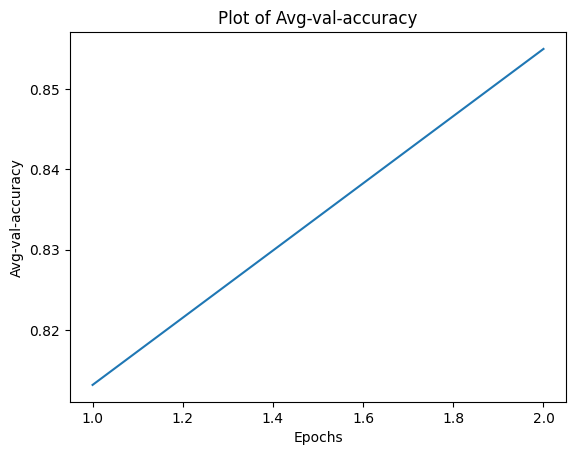

,Avg-train-loss,Avg-train-accuracy,Avg-val-loss,Avg-val-accuracy
1,0.037816,0.744296,0.037908,0.81315
2,0.037808,0.840514,0.037903,0.85500


In [39]:
plotMetric(metrics, "Avg-val-accuracy")
metrics.tail(3)

## Question Box (10pts + 5pts bonus)

**1- Do we even need normalization for tasks like this? will they provide any accuracy gain? write what you think.**

Normalization is often beneficial in tasks involving embeddings, such as contrastive learning. It ensures that the magnitude of the embeddings doesn't dominate the similarity calculations, allowing the model to focus on the direction (angle) between vectors. This can improve stability during training and lead to better accuracy, especially when using cosine similarity or dot products. However, the actual gain depends on the specific task and dataset. In many cases, normalization helps, but it's not always strictly necessary.



**2- When training a neural network, what takes the memory? mention at least 4 things.**

Training a neural network consumes memory due to several factors:

Model parameters: The weights and biases of the network.

Activations: Intermediate outputs from each layer during the forward pass, stored for backpropagation.

Gradients: Computed during backpropagation to update the model parameters.

Optimizer states: Additional memory used by optimizers like Adam (e.g., momentum, variance).

Batch data: Input data and labels loaded into memory for each batch.


**3- find out the actual Open Ai's training configuration of Clip model.**

OpenAI's CLIP was trained with the following key configurations:

Dataset: 400 million image-text pairs collected from the internet.

Batch size: 32,768.

Training steps: 32 epochs (approximately 13 billion samples).

Optimizer: Adam with weight decay and gradient clipping.

Learning rate: Warm-up followed by cosine decay.

Model architecture: Vision Transformer (ViT) or ResNet for images and Transformer for text.

Hardware: Trained on 592 V100 GPUs for 12 days.


**4- We have an alternative clip's loss implementation, write its pseudocode.**


```
def clip_loss(image_embeddings, text_embeddings, temperature):
    # Normalize embeddings
    image_embeddings = normalize(image_embeddings)
    text_embeddings = normalize(text_embeddings)

    # Compute similarity matrix
    logits = (image_embeddings @ text_embeddings.T) / temperature

    # Create targets (identity matrix for perfect alignment)
    batch_size = image_embeddings.shape[0]
    targets = torch.arange(batch_size)

    # Compute cross-entropy loss in both directions
    loss_image = cross_entropy(logits, targets)
    loss_text = cross_entropy(logits.T, targets)

    # Symmetric loss
    loss = (loss_image + loss_text) / 2
    return loss
```